In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Visualizes the computation graph using NetworkX and Matplotlib.
    Replaces Graphviz to avoid dependency on system binaries.
    """
    nodes, edges = trace(root)
    G = nx.DiGraph()
    labels = {}
    node_colors = []
    
    for n in nodes:
        uid = str(id(n))
        G.add_node(uid)
        
        # Label text with data and grad
        name = getattr(n, 'label', '')
        if name:
             lbl = f"{name}\nd:{n.data:.2f}|g:{n.grad:.2f}"
        else:
             lbl = f"d:{n.data:.2f}|g:{n.grad:.2f}"
        
        # Add operator info if it exists
        if n._op:
             lbl += f"\nop:{n._op}"
        
        labels[uid] = lbl
        node_colors.append('lightblue')
    
    for n1, n2 in edges:
        G.add_edge(str(id(n1)), str(id(n2)))
    
    # Layout the graph. spring_layout is decent for general graphs.
    # In a real DAG we might want a hierarchical layout, but this suffices.
    pos = nx.spring_layout(G, seed=42) 
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='lightblue', arrowsize=20)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    plt.title("Computation Graph")
    plt.axis('off')
    plt.show()

## 1. The Derivative
The derivative of a function $f(x)$ at a point $x$ measures the **sensitivity** of the function's output to small changes in its input. Visually, it's the **slope** of the tangent line.

Mathematical definition:
$$ f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} $$

In this formula, $h$ represents a tiny **step size** or "nudge".
*   Conceptually, we want $h$ to approach zero ($h \to 0$) to find the instantaneous rate of change.
*   Numerically, we pick a small number like `h=0.0001` to estimate the slope which is the "Run" in "Rise over Run".

In the code below, we approximate the derivative numerically by choosing a very small $h$.

In [23]:
def f(x):
    return 3*x**2 - 4*x + 5

def numerical_lim(x, h=0.0001):
    return (f(x+h) - f(x))/h

h = 0.0001
x = 3.0
print(f"Slope at {x}: {numerical_lim(x)}")

Slope at 3.0: 14.000300000063248


## 2. The `Value` Object
In `micrograd`, the `Value` object is the core building block. It wraps a single scalar number (`data`) but also keeps track of:
1.  `grad`: The derivative of the final output with respect to this value. (Initially 0).
2.  `_prev`: The parent nodes (values) that created this value.
3.  `_op`: The operation (like `+`, `*`) that created this value.

This history allows us to build a graph of computations. The `draw_dot` function below visualizes this graph.

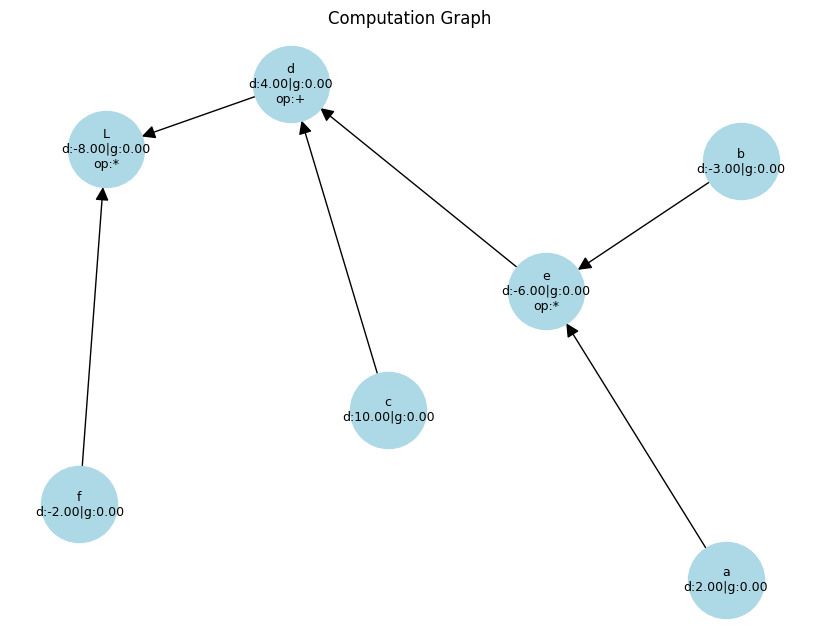

In [24]:
# Create Values
a = Value(2.0); a.label = 'a'
b = Value(-3.0); b.label = 'b'
c = Value(10.0); c.label = 'c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0); f.label = 'f'
L = d * f; L.label = 'L'

draw_dot(L)

## 3. Manual Backprop
We can check `micrograd`'s work by calculating the gradients manually using the **Chain Rule**.  
The goal is to find how much $L$ changes when any variable changes. We work backward from $L$ to $a$.

**The Rules of Gradient Flow:**

*   **The Base Case**:
    $$ \frac{\partial L}{\partial L} = 1.0 $$
    The gradient of the final output with respect to itself is always 1.0.

*   **Multiplication Node ($*$)**: Acts as a **"Switcher"**.
    *   If $z = x \cdot y$, the gradient of $x$ is $y$ times the upstream gradient.
    *   **Intuition**: If $x$ is multiplied by $y$, then $y$ determines how strong $x$'s effect is.

*   **Addition Node ($+$)**: Acts as a **"Router"**.
    *   If $z = x + y$, the gradient just flows equally to both $x$ and $y$.
    *   **Intuition**: If you add to $x$, the sum increases by exactly the same amount.

In the code below, we apply these rules step-by-step starting from L.

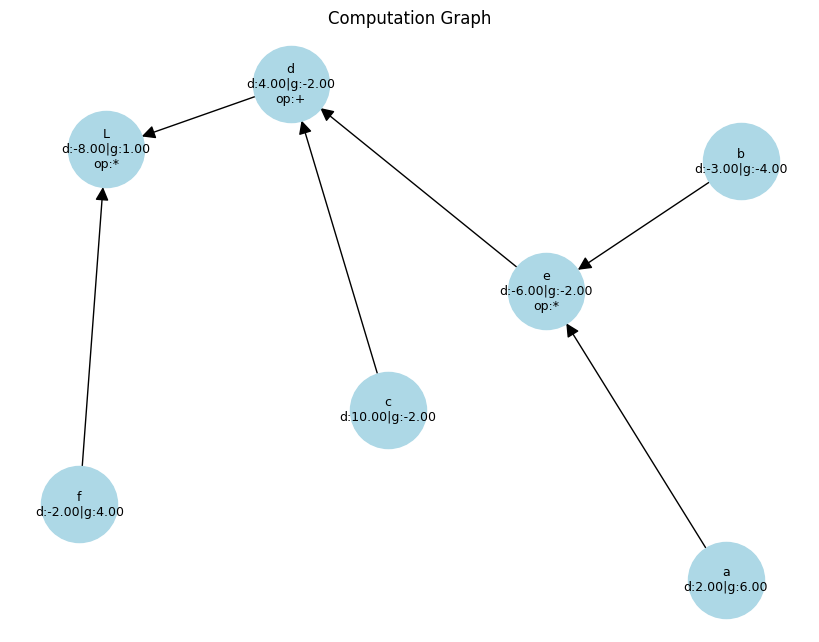

In [25]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

draw_dot(L)

## 4. Gradient Accumulation
When a variable is used multiple times, gradients from all usage points must be **added together**. This is why we use `+=` for gradients.

**The Multivariate Chain Rule:**
If a variable $a$ influences the output $L$ through multiple paths, its total gradient is the sum of the gradients from each path.

**Example: `b = a + a`**
In the code below, the variable `a` is used twice to create `b`.
*   **Path 1**: The first `a` contributes a slope of 1.0.
*   **Path 2**: The second `a` contributes a slope of 1.0.
*   **Result**: If we didn't accumulate (`+=`), we might just get 1.0. By accumulating, we correctly get `a.grad = 2.0`.

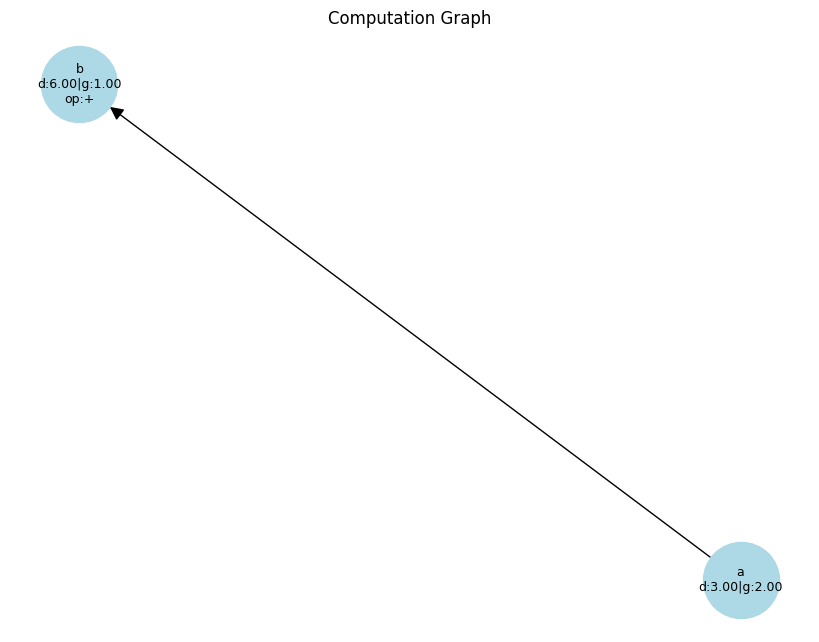

In [26]:
a = Value(3.0); a.label = 'a'
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

## 5. Building and Training a Neural Network
We can now use `micrograd.nn` to build a Multi-Layer Perceptron (MLP).
The training loop typically follows these 5 steps:
1.  **Forward Pass**: Compute the predicted output for the input data.
2.  **Calculate Loss**: Measure how wrong the prediction is (using Mean Squared Error here).
3.  **Zero Gradients**: Clear old gradients before the new pass.
4.  **Backward Pass**: Calculate gradients (`loss.backward()`).
5.  **Update**: Nudge parameters in the opposite direction of the gradient to minimize loss (**Gradient Descent**).

In [27]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

# Initialize MLP: Input dimension 3, two hidden layers of 4 neurons, output layer of 1 neuron
# We re-initialize here to ensure we start with fresh random weights each run
n = MLP(3, [4, 4, 1])

# Training Loop
# A safer learning rate (0.0001) with more steps (100) usually yields better stability
for k in range(100):
    # 1. Forward Pass
    ypred = [n(x) for x in xs]
    
    # 2. Calculate Loss (Mean Squared Error)
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # 3. Zero Gradients (Reset for new pass)
    for p in n.parameters():
        p.grad = 0.0
        
    # 4. Backward Pass (Autograd)
    loss.backward()
    
    # 5. Update steps (Gradient Descent)
    learning_rate = 0.05
    for p in n.parameters():
        p.data += -learning_rate * p.grad
    
    # Print progress every 10 steps
    if k % 10 == 0:
        print(f"Step {k}: Loss {loss.data:.4f}")

print(f"Final Step {k}: Loss {loss.data:.4f}")

# Check final results
print("\nFinal Predictions vs Ground Truth:")
for y_gt, y_p in zip(ys, ypred):
    print(f"Target: {y_gt:+.1f} | Prediction: {y_p.data:+.4f}")

Step 0: Loss 3.1152
Step 10: Loss 2.4409
Step 20: Loss 3.1382
Step 30: Loss 0.4171
Step 40: Loss 0.0698
Step 50: Loss 1.1079
Step 60: Loss 0.7279
Step 70: Loss 0.6555
Step 80: Loss 0.6210
Step 90: Loss 0.5792
Final Step 99: Loss 0.3276

Final Predictions vs Ground Truth:
Target: +1.0 | Prediction: +0.8861
Target: -1.0 | Prediction: -1.4280
Target: -1.0 | Prediction: -1.3443
Target: +1.0 | Prediction: +0.8861
